In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn import metrics
from sklearn.metrics import confusion_matrix, f1_score
import pickle
import random, os, json
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, GRU, Dropout, Dense
from tensorflow.keras import backend as K
import sys
sys.path.append("../../Libraries/")
import utils

# Functions

In [2]:
class Hadamard(tf.keras.layers.Layer):
    def __init__(self,
                 allow_training=True,
                 l1_penalty=0.0,
                 **kwargs):
        assert allow_training or (w_vec is not None), \
            "ERROR: non-trainable w_vec must be initialized"
        self.allow_training = allow_training
        self.l1_penalty = l1_penalty
        super().__init__(**kwargs)
        self.supports_masking = True
        return

    def build(self, input_shape):
        batch_size, nun_time_steps, num_feats = input_shape
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(1, nun_time_steps, num_feats),
                                      initializer='glorot_uniform',
                                      trainable=True, 
                                      regularizer=tf.keras.regularizers.L1(self.l1_penalty))
        super(Hadamard, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, x):
        return x * self.kernel

    def get_weights(self):
        return self.kernel
    
    def compute_output_shape(self, input_shape):
        print(input_shape)
        return input_shape

In [3]:
def build_model(hyperparameters):    
    dynamic_input = tf.keras.layers.Input(shape=(hyperparameters["time_step"], hyperparameters['layers'][0]))
    masked = tf.keras.layers.Masking(mask_value=hyperparameters['mask_value'])(dynamic_input)

    hadamard_layer = Hadamard(allow_training=True, l1_penalty=hyperparameters['l1_penalty'])
    weighted_tensor = hadamard_layer(masked)
    
    gru_encoder = tf.keras.layers.GRU(
        hyperparameters['layers'][1],
        dropout=hyperparameters['dropout_rate'],
        return_sequences=False,
        activation='tanh',
        use_bias=True
    )(weighted_tensor)
    
    

    output = tf.keras.layers.Dense(1, activation="sigmoid")(gru_encoder)

    model = tf.keras.Model(dynamic_input, [output])
    myOptimizer = tf.keras.optimizers.Adam(learning_rate=hyperparameters['lr_scheduler'])
    customized_loss = utils.weighted_binary_crossentropy(hyperparameters)
    model.compile(loss=customized_loss, optimizer=myOptimizer)
        
    return model, hadamard_layer, weighted_tensor

In [4]:
def run_network(X_train, X_val, y_train, y_val, hyperparameters, seed):
    model = None
    model, hadamard_layer, weighted_tensor = build_model(hyperparameters)
    earlystopping = None
    try:
        earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      min_delta=hyperparameters["mindelta"],
                                                      patience=hyperparameters['patience'],
                                                      restore_best_weights=True,
                                                      mode="min")
        hist = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                         callbacks=[earlystopping], batch_size=hyperparameters['batch_size'], epochs=hyperparameters['epochs'],
                         verbose=hyperparameters['verbose'])
        
        return model, hadamard_layer, weighted_tensor, hist, earlystopping
    except KeyboardInterrupt:
        print ('Training duration (s) : ', time.time() - global_start_time)
        return model, y_test, 0, 0


In [5]:
def myCVGrid(hyperparameters, dropout_rate, lr_sch, layers, l1_penalty, split, seed):
    bestHyperparameters = {}
    bestMetricDev = np.inf

    for k in range(len(dropout_rate)):
        for l in range(len(layers)):
            for m in range(len(lr_sch)):
                for it in range(len(l1_penalty)):
                    hyperparameters_copy = hyperparameters.copy()
                    hyperparameters_copy['dropout_rate'] = dropout_rate[k]
                    hyperparameters_copy['layers'] = layers[l]
                    hyperparameters_copy['lr_scheduler'] = lr_sch[m]
                    hyperparameters_copy['l1_penalty'] = l1_penalty[it]
                    
                    v_early = []
                    v_metric_dev = []
                    v_hist = []
                    v_val_loss = []
                   
                    for n in range(5):
                        #Load train and validation 
                        X_train = np.load("../../ORIGINAL_DATA/splits_14_days/notbalanced/split_" + str(i) +
                                              "/X_train_tensor_" + str(n)+ ".npy")
                        y_train = pd.read_csv("../../ORIGINAL_DATA/splits_14_days/notbalanced/split_" + str(i) +
                                              "/y_train_" + str(n)+ ".csv",
                                             index_col=0)

                        X_val = np.load("../../ORIGINAL_DATA/splits_14_days/notbalanced/split_" + str(i) +
                                            "/X_val_tensor_" + str(n)+ ".npy")
                        y_val = pd.read_csv("../../ORIGINAL_DATA/splits_14_days/notbalanced/split_" + str(i) +
                                            "/y_val_" + str(n)+ ".csv",
                                           index_col=0)

                        # Reset keras
                        utils.reset_keras()
                        
                        # Train the network
                        model, hadamard_layer, weighted_tensor, hist, early = run_network(
                            X_train, X_val,
                            y_train.individualMRGerm.values, y_val.individualMRGerm.values,
                            hyperparameters_copy,
                            seed
                        )
                        del model
                        v_early.append(early)
                        v_hist.append(hist)
                        v_val_loss.append(np.min(hist.history["val_loss"]))
                        
                    metric_dev = np.mean(v_val_loss)
                    if metric_dev < bestMetricDev:
                        bestMetricDev = metric_dev
                        bestHyperparameters = {
                            'dropout_rate': dropout_rate[k],
                            'layers': layers[l],
                            'lr_scheduler': lr_sch[m],
                            'l1_penalty': l1_penalty[it]
                            
                        }

    return bestHyperparameters, X_train, X_val, y_train, y_val

# Hyperparameters

In [6]:
#%%
seeds = [20, 30, 45, 70]
results = ""
debug = True
balance = True
tensor = True

epochs = 10000
batch_size = 128
inputShape = 56
time_step = 14

layers = [[inputShape, 3, 1], [inputShape, 5, 1], [inputShape, 8, 1], [inputShape, 10, 1], 
          [inputShape, 15, 1], [inputShape, 20, 1],  [inputShape, 25, 1], [inputShape, 30, 1], 
          [inputShape, 35, 1], [inputShape, 40, 1], [inputShape, 50, 1]]

lr_scheduler = [0.0001, 0.001, 0.01, 0.1]
dropout_rate = [0.0, 0.1, 0.2, 0.3]

l1_penalty = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

w2 = 0.18
w1 = 0.82

hyperparameters = {
    "epochs":epochs,
    "input_shape": inputShape,
    'batch_size': batch_size,
    'patience':30,
    'time_step': time_step,
    "w1":w1, "w2":w2, 
    'mask_value':666,
    'monitor': 'val_loss', "mindelta": 0,
    'balance': balance,
    'optimizer':'adam',
    'verbose':0,
    'kfold':5,
    'level':3
}

# Code

In [7]:
run_model = False
n = 4

if run_model:
    v_early = []
    loss_dev = []
    v_models = []
    bestHyperparameters_bySplit = {}
    y_pred_by_split = {}
    weights = []
    hadamard_scores_data = []
    hadamard_scores_data_2 = []

    for i in [1, 2, 3]:
        X_test = np.load("../../ORIGINAL_DATA/splits_14_days/notbalanced/split_" + str(i) + "/X_test_tensor.npy")
        y_test = pd.read_csv("../../ORIGINAL_DATA/splits_14_days/notbalanced/split_" + str(i) + "/y_test.csv",
                            index_col=0)

    
        bestHyperparameters, X_train, X_val, y_train, y_val = myCVGrid(hyperparameters,
                                                                       dropout_rate,
                                                                       lr_scheduler,
                                                                       layers,
                                                                       l1_penalty,
                                                                       i,                                                              
                                                                       seeds[i],
                                                                      )
        bestHyperparameters_bySplit[str(i)] = bestHyperparameters
    
        # #Save best hyperparameters for current split
        split_directory = './Results_HAM/split_' + str(i)
        if not os.path.exists(split_directory):
            os.makedirs(split_directory)
    
        with open(os.path.join(split_directory, f"bestHyperparameters_split_{i}.pkl"), 'wb') as f:
            pickle.dump(bestHyperparameters, f)
    
    
        hyperparameters = {
            "w1":hyperparameters["w1"], "w2":hyperparameters["w2"],                                    
            "time_step": hyperparameters["time_step"],
            'epochs':  hyperparameters["epochs"],
            'batch_size': hyperparameters["batch_size"],
            'mask_value': hyperparameters["mask_value"],
            'earlyStopping': True,
            'kfold': hyperparameters["kfold"],
            'monitor': hyperparameters["monitor"],
            "mindelta": hyperparameters["mindelta"],
            "patience": hyperparameters["patience"],
            'balance': hyperparameters["balance"],
            "dropout_rate": bestHyperparameters["dropout_rate"],
            "layers": bestHyperparameters["layers"],
            "lr_scheduler": bestHyperparameters["lr_scheduler"],
            'l1_penalty': bestHyperparameters["l1_penalty"], 
            "level": 3, 'verbose': 0
        }
    
        #Try on test
        utils.reset_keras()

    
        model, hadamard_layer, weighted_tensor, hist, early = run_network(
            X_train, X_val, y_train,
            y_val,
            hyperparameters, 
            seeds[i]
        )    
        
        hadamard_scores_by_split = hadamard_layer.kernel[0].numpy().T #(72,14)
        
        with open(os.path.join(split_directory, f"hadamard_matrix_split_{i}.pkl"), 'wb') as f:
            pickle.dump(hadamard_scores_by_split, f)
                    
        v_models.append(model)
        loss_dev.append(hist.history['val_loss'])
    
        y_pred = model.predict(x=[X_test])
        y_pred_by_split[str(i)] = y_pred
        
        with open(os.path.join(split_directory, f"y_pred_split_{i}.pkl"), 'wb') as f:
            pickle.dump(y_pred, f)
    
        # Calculate metrics
        metrics_dict = utils.calculate_and_save_metrics(
        y_test.individualMRGerm.values, 
        y_pred, 
        split_directory, 
        split_index=i
        )

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rcParams
rcParams['font.size'] = 38

keys = [
    'AMG', 'ATF', 'CAR', 'CF1', 'CF2', 'CF3', 'CF4', 'Others', 'GCC', 'GLI', 'LIN', 'LIP', 'MAC',
    'MON', 'NTI',  'OTR', 'OXA', 'PAP', 'PEN', 'POL', 'QUI', 'SUL', 'TTC',
    
    r'$acinet._{pc}$', r'$enterob._{pc}$', r'$enteroc._{pc}$', 
    r'$pseudo._{pc}$', r'$staph._{pc}$', r'$stenot._{pc}$', r'$others_{pc}$',
    
    'Mech. Vent.',

    '# pat.', '# MDR pat.',
    
    r'$AMG_{n}$', r'$ATF_{n}$', r'$CAR_{n}$', r'$CF1_{n}$', r'$CF2_{n}$', r'$CF3_{n}$',
    r'$CF4_{n}$', r'$Others_{n}$', r'$GCC_{n}$', r'$GLI_{n}$', r'$LIN_{n}$', r'$LIP_{n}$', r'$MAC_{n}$',
    r'$MON_{n}$', r'$NTI_{n}$', r'$OTR_{n}$', r'$OXA_{n}$', r'$PAP_{n}$',
    r'$PEN_{n}$', r'$POL_{n}$', r'$QUI_{n}$', r'$SUL_{n}$', r'$TTC_{n}$']


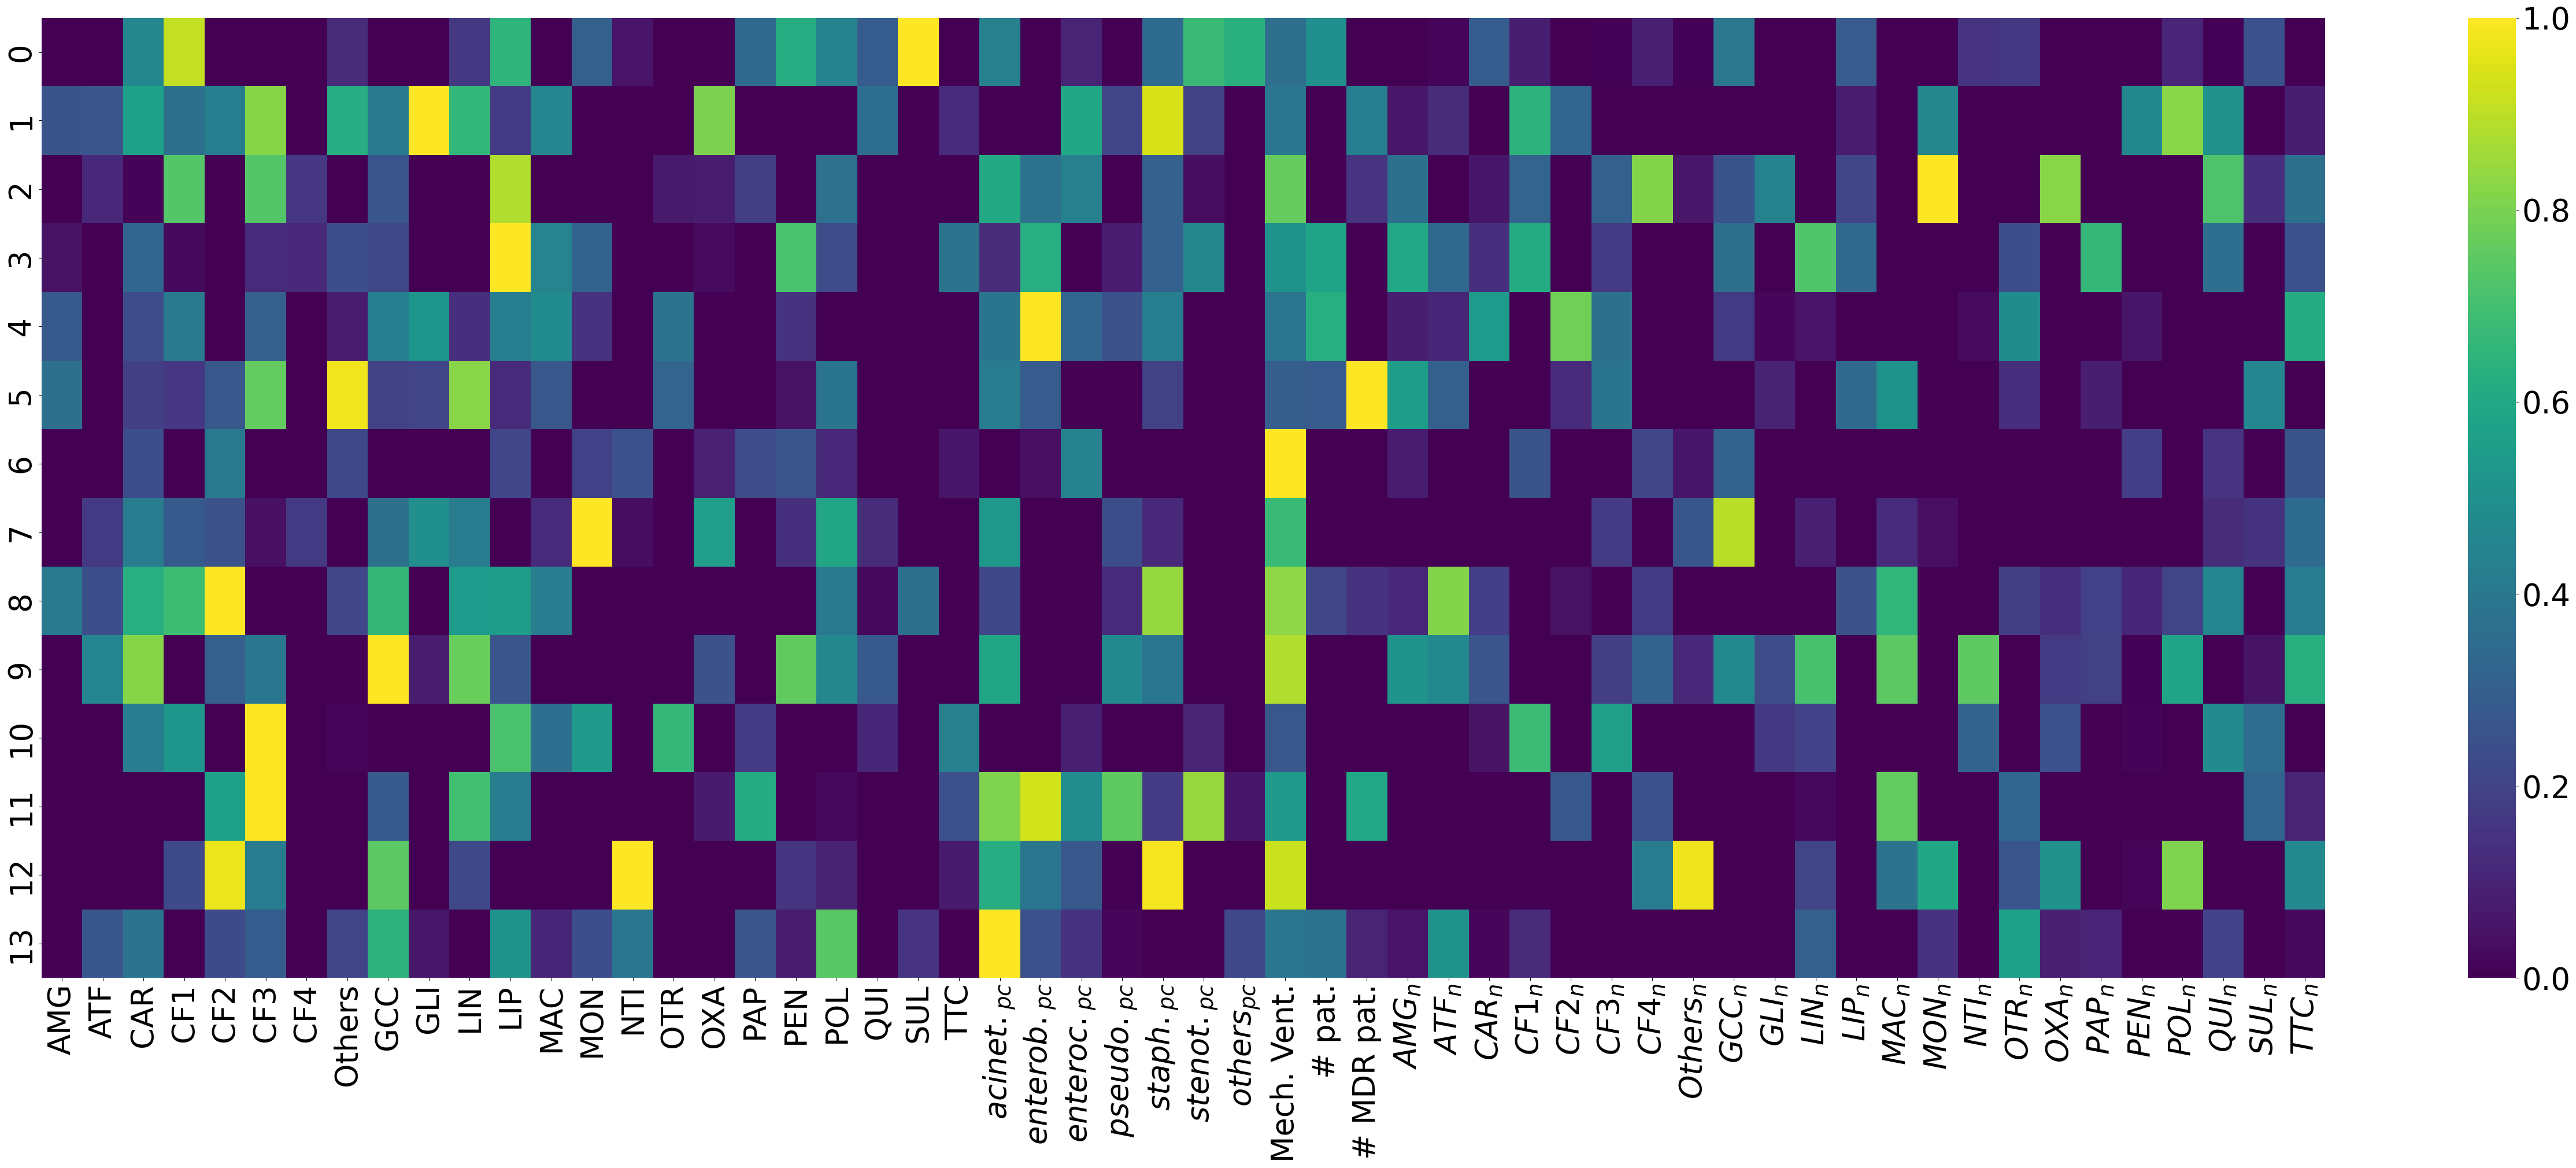

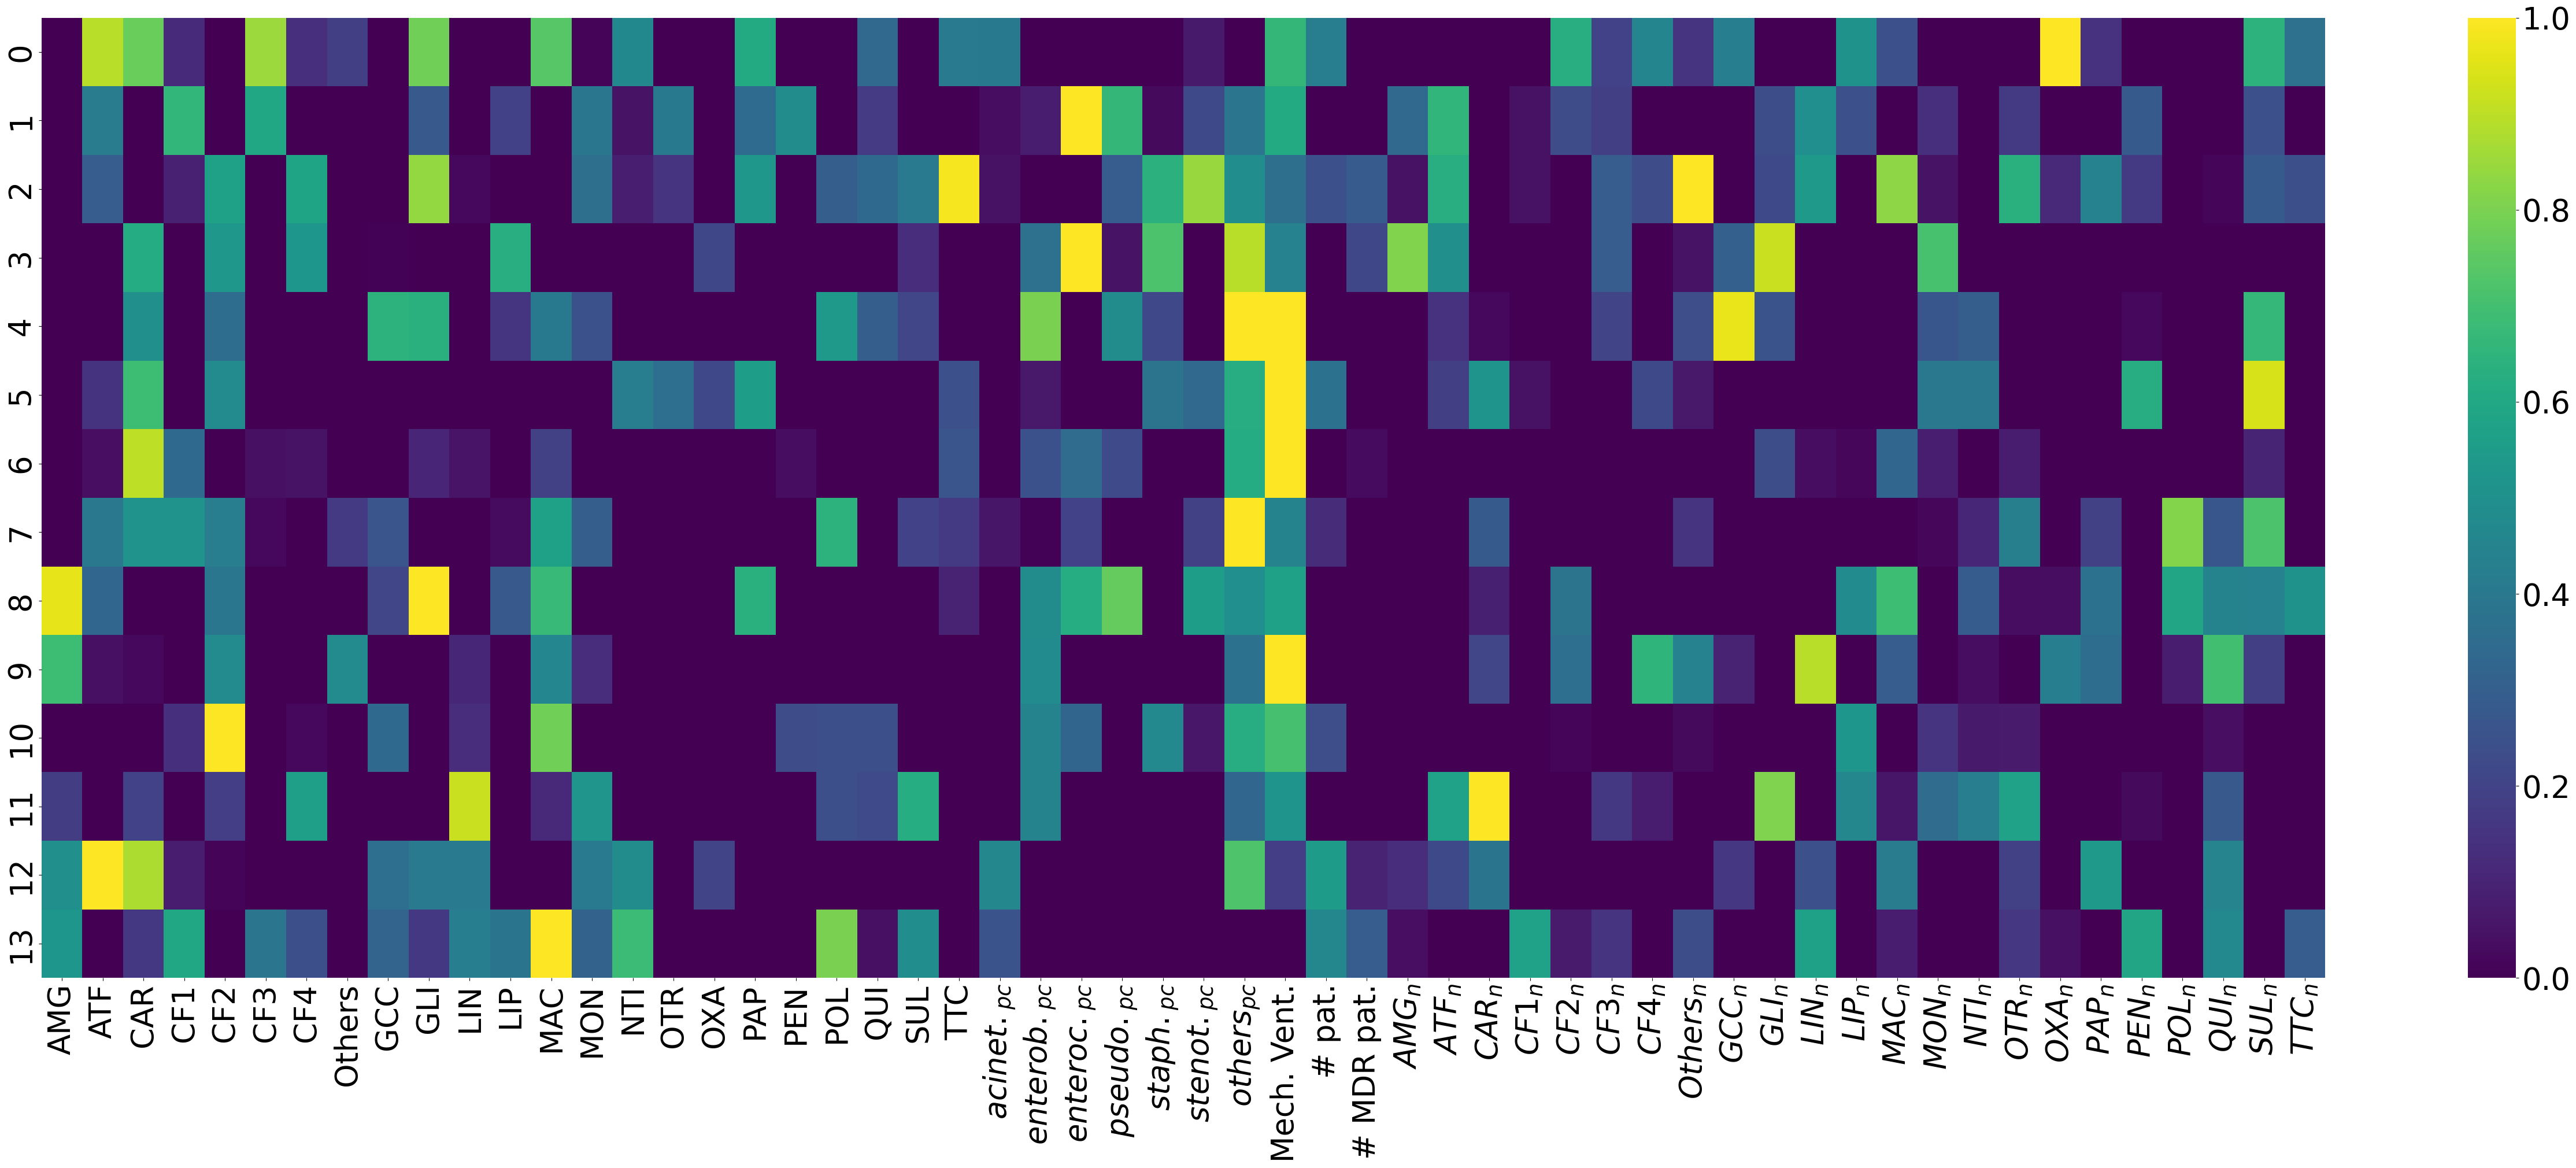

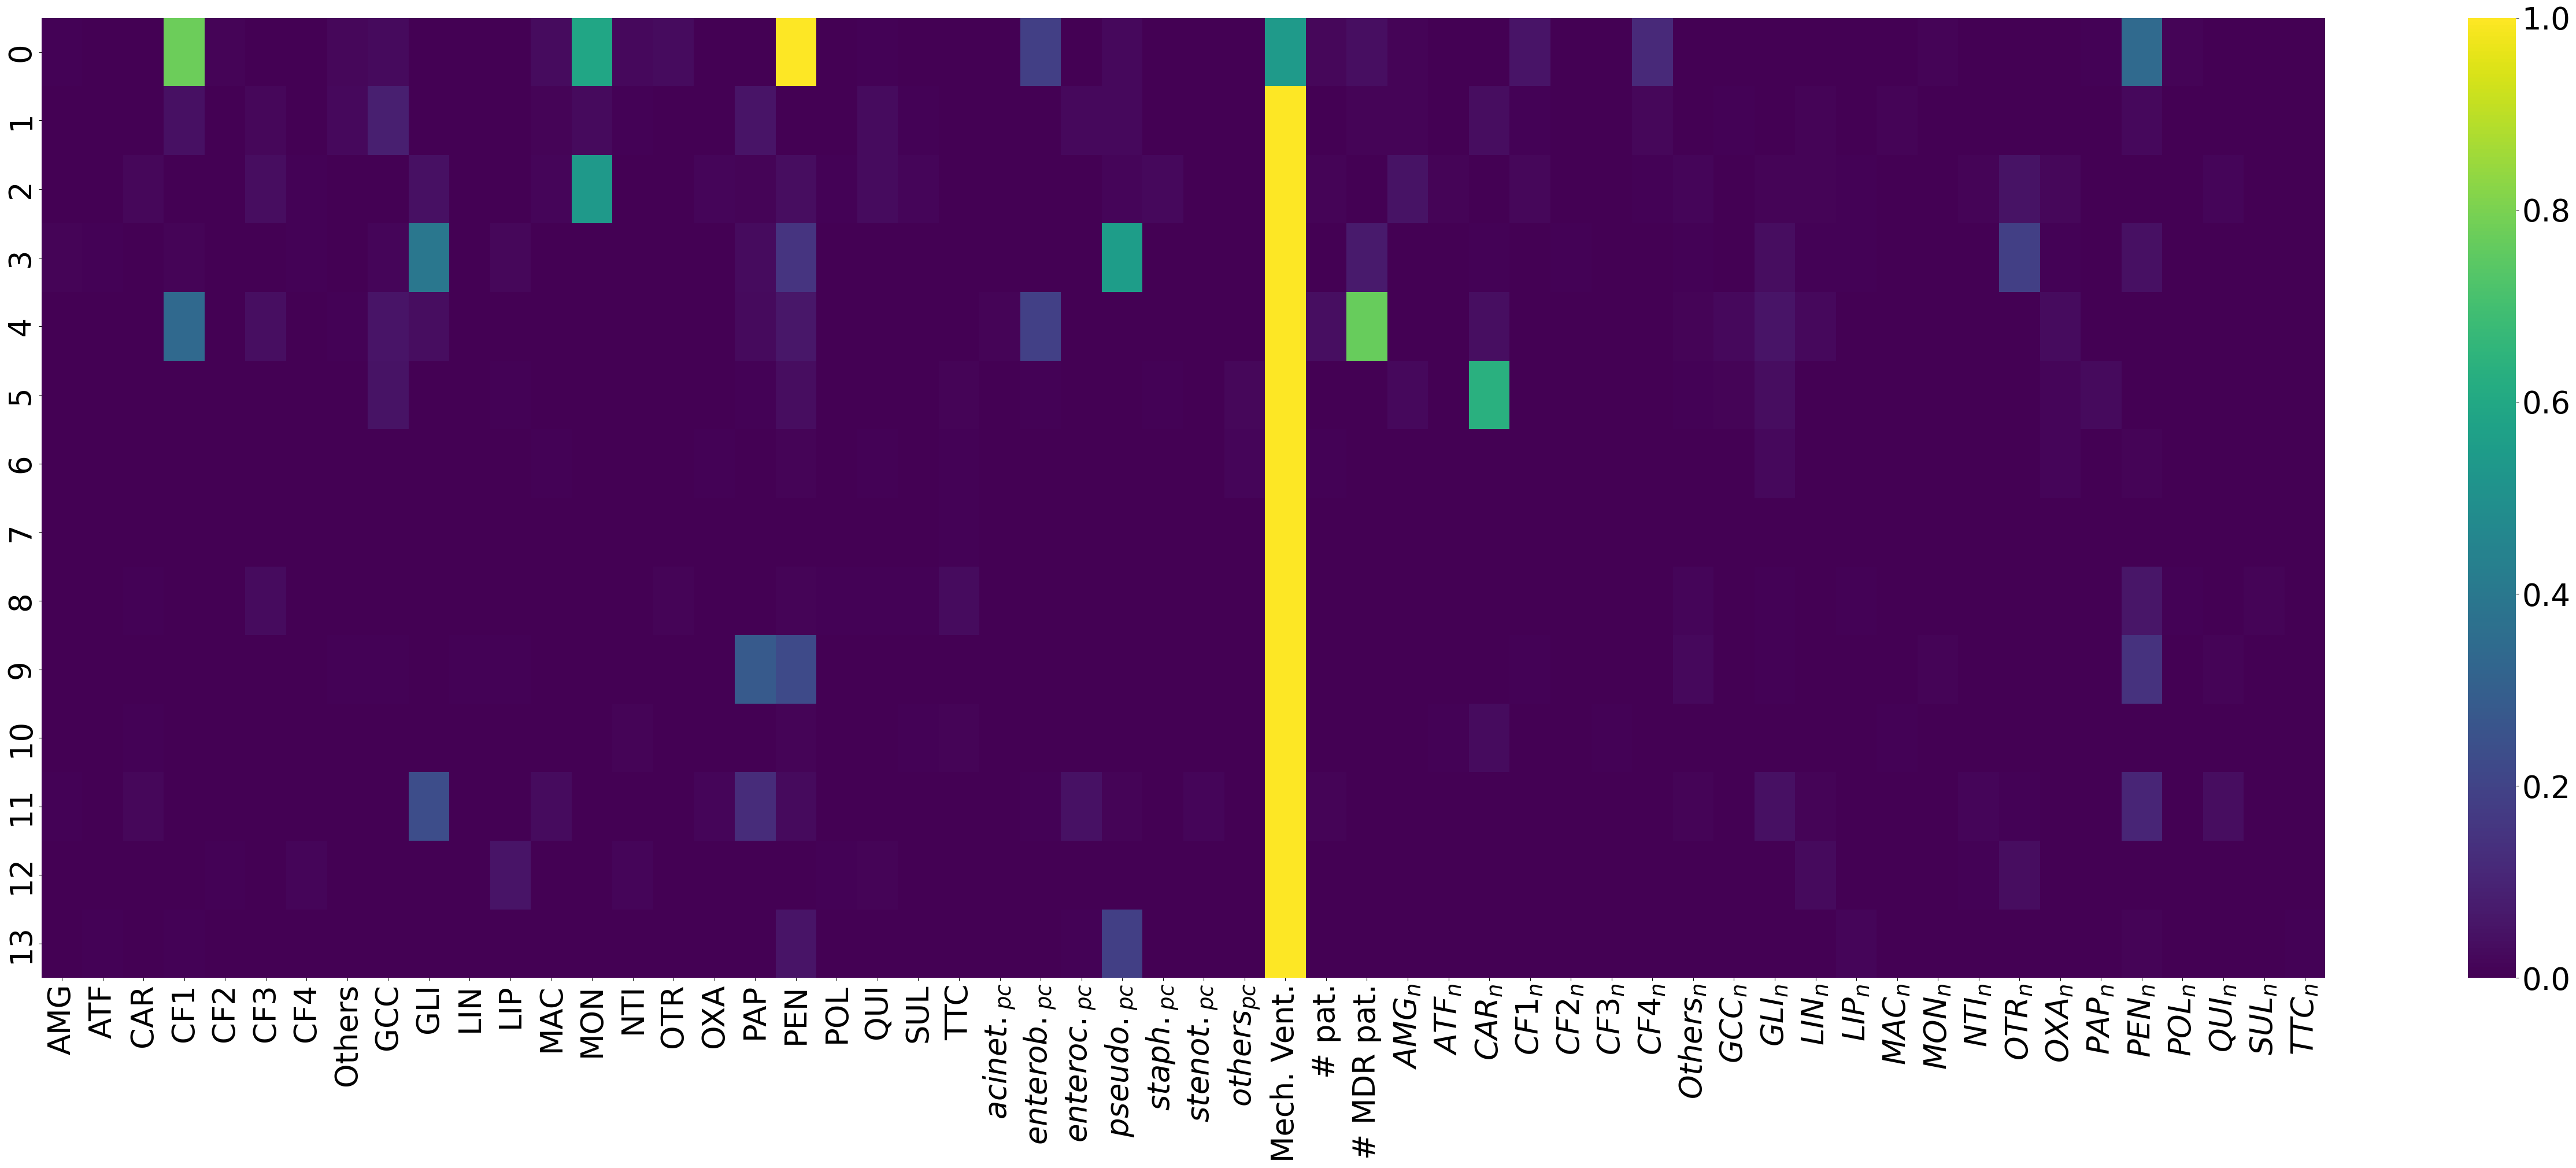

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import os
import pickle
def load_from_pickle(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

for i in [1, 2, 3]:
    directory = f'./Results_HAM/split_{i}'
    hadamard_scores_data = load_from_pickle(os.path.join(directory, f"hadamard_matrix_split_{i}.pkl"))
    
    data = hadamard_scores_data
    mask = data < 0
    data[mask] = 0

    scaler = MinMaxScaler()
    data_normalized = scaler.fit_transform(data)

    plt.subplots(figsize=(50, 20)) 

    heatmap = sns.heatmap(
        data_normalized.T, 
        annot=False, 
        cmap='viridis',
        xticklabels=keys,
        yticklabels=range(14),
    )

    plt.tight_layout(pad=0)
    plt.savefig('./Figures/heatmap_HAM_s'+str(i)+'.pdf', bbox_inches='tight', pad_inches=0)
    plt.show()
